<a href="https://colab.research.google.com/github/vansh-31/ML-Projects/blob/main/Food-Vision/Food_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Food Vision

__Aim:__ This Project aims to classify the different images of food using the food101 dataset



In [ ]:
# @title Downloading and Importing Required Libraries
!pip install wandb
import wandb
from wandb.keras import WandbMetricsLogger
from pytz import timezone
from collections import defaultdict
import datetime
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
sns.set_style("dark")
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input,Dense, Flatten, Conv2D, MaxPool2D, Activation,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import TensorBoard,ModelCheckpoint,EarlyStopping
%load_ext tensorboard
tf.__version__

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


'2.14.0'

In [ ]:
wandb.login()

wandb: Currently logged in as: vanshgawra008. Use `wandb login --relogin` to force relogin


True

### Creating some helper functions

In [ ]:
def compare_histories(original_history, new_history, initial_epochs):
    """
    Compares two TensorFlow model History objects.

    Args:
      original_history: History object from original model (before new_history)
      new_history: History object from continued model training (after original_history)
      initial_epochs: Number of epochs in original_history (new_history plot starts from here)
    """

    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [ ]:
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics
    """
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    epochs = [x for x in range(len(history.history["loss"]))] # how many epochs did we run for?
    fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(16,7))
    sns.lineplot( x=epochs,y = loss, ax=ax1,label="Training Loss" )
    sns.lineplot( x=epochs,y = val_loss, ax=ax1, label="Validation Loss" )
    sns.lineplot( x=epochs,y = accuracy, ax=ax2,label="Training Accuracy" )
    sns.lineplot( x=epochs,y = val_accuracy, ax=ax2, label="Validation Accuracy" )
    ax1.set_title("Loss")
    ax2.set_title("Accuracy")
    ax2.set_ylim((0,1))
    ax2.set_yticks(np.linspace(0,1,11), labels=[f"{x*100:.0f}%" for x in np.linspace(0,1,11)] )

In [ ]:
def random_plot_predict(model,num_samples=1,class_names=class_names):
    samples = []
    for i in range(num_samples):
        samples.append(random.randint(0,500))
    images = []
    labels = []
    pred_probs = []
    pred_labels = []
    i = 0
    for image,label in test_data.unbatch():
        if i in samples:
            images.append(image.numpy().astype(int))
            pred = tf.squeeze( model.predict(tf.expand_dims(image,0)) ).numpy()
            top_10_preds = np.argsort(-pred)[:10]
            pred_probs.append(pred[top_10_preds])
            pred_labels.append(class_names[top_10_preds])
            labels.append( class_names[label.numpy()] )
            if len(images) == num_samples:
                break
        i += 1
    fig = plt.figure(figsize=(20, num_samples*7 ))
    gs = GridSpec(num_samples, 2, width_ratios=[1, 3],hspace=0.5)
    for row in range(num_samples):
        ax1 = plt.subplot(gs[row, 0])
        ax2 = plt.subplot(gs[row, 1])
        ax1.imshow(images[row])
        ax1.set_title(f"{labels[row]}")
        sns.barplot(x=pred_labels[row],y=pred_probs[row],ax=ax2)
        ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
        ax2.set_ylim(0, 1)

In [ ]:
# @title Defining Constants
BATCH_SIZE = 32
IMAGE_SIZE = (224,224)
INPUT_SHAPE = (224,224,3)
CHECKPOINT_PATH = "model_checkpoints"

## Use TensorFlow Datasets to Download Data

In [ ]:
tfds.list_builders()

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'answer_equivalence',
 'arc',
 'asqa',
 'asset',
 'assin2',
 'bair_robot_pushing_small',
 'bccd',
 'beans',
 'bee_dataset',
 'beir',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'ble_wind_field',
 'blimp',
 'booksum',
 'bool_q',
 'bot_adversarial_dialogue',
 'bucc',
 'c4',
 'c4_wsrs',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cardiotox',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'cfq',
 'cherry_blossoms',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar100_n',
 'cifar10_1',
 'cifar10_corrupted',
 'cifar10_h',
 'cifar10_n',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'clic',
 'clinc_oos',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coco_captions',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'common_voice',
 'conll2002',
 

In [ ]:
# List all available datasets
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print("food101" in datasets_list) # is our target dataset in the list of TFDS datasets?

True


In [ ]:
(train_data,test_data),data_info = tfds.load(
    name="food101",
    split=["train","validation"],
    as_supervised=True,
    with_info=True
)

## Exploring the Food101 data from TensorFlow Datasets

In [ ]:
# Features of Food101 from TFDS
data_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [ ]:
# Get the class names
class_names = np.array(data_info.features["label"].names)
class_names[:10]

array(['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio',
       'beef_tartare', 'beet_salad', 'beignets', 'bibimbap',
       'bread_pudding', 'breakfast_burrito'], dtype='<U23')

In [ ]:
# Take one sample of the train data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)

In [ ]:
# What does one sample of our training data look like?
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image datatype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
  """)


  Image shape: (512, 512, 3)
  Image datatype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 56
  Class name (str form): huevos_rancheros
  


In [ ]:
# What does our image tensor from TFDS's Food101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[233, 253, 251],
        [231, 253, 250],
        [228, 254, 251],
        ...,
        [ 85,  82,  89],
        [ 68,  67,  75],
        [ 57,  57,  67]],

       [[232, 254, 252],
        [229, 254, 251],
        [226, 255, 251],
        ...,
        [121, 116, 120],
        [100,  99, 104],
        [ 86,  85,  91]],

       [[228, 254, 253],
        [226, 255, 253],
        [223, 255, 252],
        ...,
        [164, 159, 155],
        [145, 141, 138],
        [128, 127, 125]],

       ...,

       [[ 66, 112, 164],
        [ 67, 113, 163],
        [ 55,  99, 148],
        ...,
        [  5,  14,  23],
        [  9,  18,  27],
        [  8,  17,  26]],

       [[ 76, 123, 177],
        [ 75, 122, 176],
        [ 70, 116, 168],
        ...,
        [  5,  14,  23],
        [  9,  18,  25],
        [  7,  16,  23]],

       [[ 80, 129, 185],
        [ 71, 121, 174],
        [ 74, 121, 175],
        ...,
        [  7,  16,  2

In [ ]:
# What are the min and max values of our image tensor?
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### We can see that the images are not normalized and comes in different shapes

### Plot an image from TensorFlow Datasets

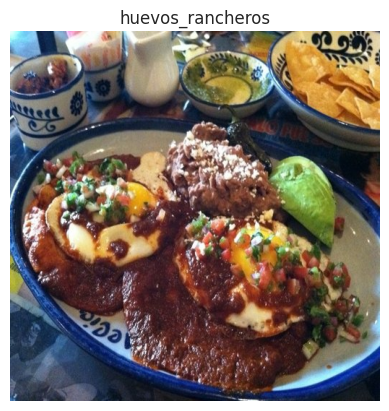

In [ ]:
# Plot an image tensor
plt.imshow(image)
plt.title(class_names[label.numpy()]) # Add title to image to verify the label is assosciated with the right image
plt.axis(False);

## Create preprocessing functions for our data

In [ ]:
# Our data comes in the tuple structure: (image, label)

In [ ]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_size=IMAGE_SIZE):
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes
  image to [img_shape, img_shape, colour_channels]
  """
  image = tf.image.resize(image, img_size) # reshape target image
  # image = image/255. # scale image values (not required with EfficientNetBX models from tf.keras.applications)
  return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [ ]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}..., \nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n{preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[233 253 251]
  [231 253 250]
  [228 254 251]
  ...
  [ 85  82  89]
  [ 68  67  75]
  [ 57  57  67]]

 [[232 254 252]
  [229 254 251]
  [226 255 251]
  ...
  [121 116 120]
  [100  99 104]
  [ 86  85  91]]]..., 
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
[[[230.65816 253.64285 251.     ]
  [222.99998 254.97449 252.19388]
  [207.06633 255.      250.36734]
  ...
  [140.66287 129.52519 121.22428]
  [121.14268 115.26515 116.95397]
  [ 83.95363  83.08119  89.63737]]

 [[221.47449 254.37755 253.33163]
  [214.5102  255.      253.92348]
  [198.41327 254.58673 251.96939]
  ...
  [208.66318 195.82143 173.40823]
  [197.03056 190.1071  174.83162]
  [175.54036 171.6169  161.21384]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


## Batch & prepare datasets

In [ ]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
# Map preprocessing function to training (and parallelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Create modelling callbacks

In [ ]:
# Create Tensor Board Callback
def createTensorBoardCallback(root_dir="logs",project="Food_Vision",model_name="model"):
    return TensorBoard(  log_dir = f"{root_dir}/{project}/{model_name}/{datetime.datetime.now(timezone('Asia/Kolkata')).strftime('%Y-%m-%d___%H:%M:%S.%f')}/" )

In [ ]:
# Creating a ModelCheckpoint callback to save the best model (weights only for better performance) during training
def model_checkpoint(model_name):
  return ModelCheckpoint(
      f"{CHECKPOINT_PATH}/{model_name}/",
      montior="val_acc",
      save_best_only=True,
      save_weights_only=True,
      verbose=0) # don't print whether or not model is being saved

In [ ]:
# Creating a Early Stopping CallBack
def early_stopping():
  return EarlyStopping(
      min_delta=0.003,
      patience=2,
)

## Setup mixed precision training

> Mixed precision utilizes a combination of float32 and float16 data types to speed up model performance.


In [ ]:
# Turn on mixed precision training
keras.mixed_precision.set_global_policy('mixed_float16') # set global data policy to mixed precision

In [ ]:
keras.mixed_precision.global_policy()

<Policy "mixed_float16">

## Build feature extraction model

In [ ]:
# Create base model
base_model = keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create functional model
inputs = Input(shape=INPUT_SHAPE,name="Input_Layer")
# Note: EfficientNetBX models have rescaling built-in but if your model doesn't you can have a layer like below
# x = preprocessing.Rescaling(1./255)(x)
x = base_model(inputs,training=False) # makes sure layers which should be in inference mode only stay like that
x = GlobalAveragePooling2D(name="Global_Avg_Pooling_Layer")(x)
x = Dense(len(class_names),name="Output_Layer")(x)
outputs = Activation(activation="softmax",dtype=tf.float32,name="Output_Activation_Layer")(x)

model = keras.Model(inputs,outputs)

# Compile the model
model.compile(
    loss=SparseCategoricalCrossentropy(),
    optimizer=Adam(),
    metrics=["accuracy"]
)

# Get the Summary of the Data
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 Global_Avg_Pooling_Layer (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 Output_Layer (Dense)        (None, 101)               129381    
                                                                 
 Output_Activation_Layer (A  (None, 101)               0         
 ctivation)                                                      
                                                             

### Checking layer dtype policies (are we using mixed precision?)

In [ ]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

Input_Layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
Global_Avg_Pooling_Layer True float32 <Policy "mixed_float16">
Output_Layer True float32 <Policy "mixed_float16">
Output_Activation_Layer True float32 <Policy "float32">


Going through the above we see:

- layer.name: the human readable name of a particular layer
- layer.trainable: is the layer trainable or not? (if False, the weights are frozen)
- layer.dtype: the data type a layer stores its variables in
- layer.dtype_policy: the data type policy a layer computes on its variables with

In [ ]:
# Check the dtype_policy attributes of layers in the base model
for layer in model.layers[1].layers[:20]: # check the layers of the base model (layer at index 1 of `model`)
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
rescaling_1 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <

In [ ]:
keras.mixed_precision.global_policy()

<Policy "mixed_float16">

## Fit the feature extraction model

In [ ]:
# Intialize the Project on Weights and Biases
run = wandb.init(project="Food_Vision")

# Fit the feature extraction model with callbacks
feature_extraction_model_history = model.fit(
    train_data,
    epochs=100,
    steps_per_epoch=(len(train_data)),
    validation_data=test_data,
    validation_steps=int( 0.3 * len(test_data) ), # Evalutae on 30% of testing data for quicker results
    callbacks=[
        createTensorBoardCallback(
            model_name="Feature_Extraction_Model"
        ),
        WandbMetricsLogger(),
        model_checkpoint("Feature_Extraction_Model"),
        early_stopping()
    ]
)

Epoch 1/100
2368/2368 [==============================] - 217s 81ms/step - loss: 1.7159 - accuracy: 0.5823 - val_loss: 1.1431 - val_accuracy: 0.6945
Epoch 2/100
2368/2368 [==============================] - 192s 80ms/step - loss: 1.1991 - accuracy: 0.6884 - val_loss: 1.0457 - val_accuracy: 0.7173
Epoch 3/100
2368/2368 [==============================] - 197s 82ms/step - loss: 1.0538 - accuracy: 0.7235 - val_loss: 1.0042 - val_accuracy: 0.7306
Epoch 4/100
2368/2368 [==============================] - 192s 80ms/step - loss: 0.9597 - accuracy: 0.7481 - val_loss: 0.9880 - val_accuracy: 0.7284
Epoch 5/100
2368/2368 [==============================] - 196s 82ms/step - loss: 0.8877 - accuracy: 0.7666 - val_loss: 0.9809 - val_accuracy: 0.7317
Epoch 6/100
2368/2368 [==============================] - 188s 79ms/step - loss: 0.8326 - accuracy: 0.7802 - val_loss: 0.9772 - val_accuracy: 0.7342
Epoch 7/100
2368/2368 [==============================] - 193s 80ms/step - loss: 0.7864 - accuracy: 0.7921 - val_

In [ ]:
# Get the best model (Update the weights)
model.load_weights(f"{CHECKPOINT_PATH}/Feature_Extraction_Model/")

In [ ]:
# Evaluate on full test data
feature_extraction_model_results = model.evaluate(test_data)
feature_extraction_model_results

790/790 [==============================] - 54s 68ms/step - loss: 0.9767 - accuracy: 0.7333


[0.9766765236854553, 0.7332673072814941]

Since we got the accuracy of 73% which is pretty good for a feature extraction model<br/>
So,we will continue with fine tuning to see if the results improve

In [ ]:
# Save the model
model.save("Food_Vision_Feature_Extraction_Model.h5")
# Upload it on Weights and Biases
wandb.save('Food_Vision_Feature_Extraction_Model.h5')
# Finish the current run
wandb.finish()

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


epoch/accuracy,▁▄▆▆▇▇██
epoch/epoch,▁▂▃▄▅▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▃▂▂▁▁
epoch/val_accuracy,▁▅▇▇██▇▇
epoch/val_loss,█▄▂▁▁▁▁▂
epoch/accuracy,0.80191
epoch/epoch,7
epoch/learning_rate,0.001
epoch/loss,0.74643
epoch/val_accuracy,0.72956


Let's track the model's progress over the epochs

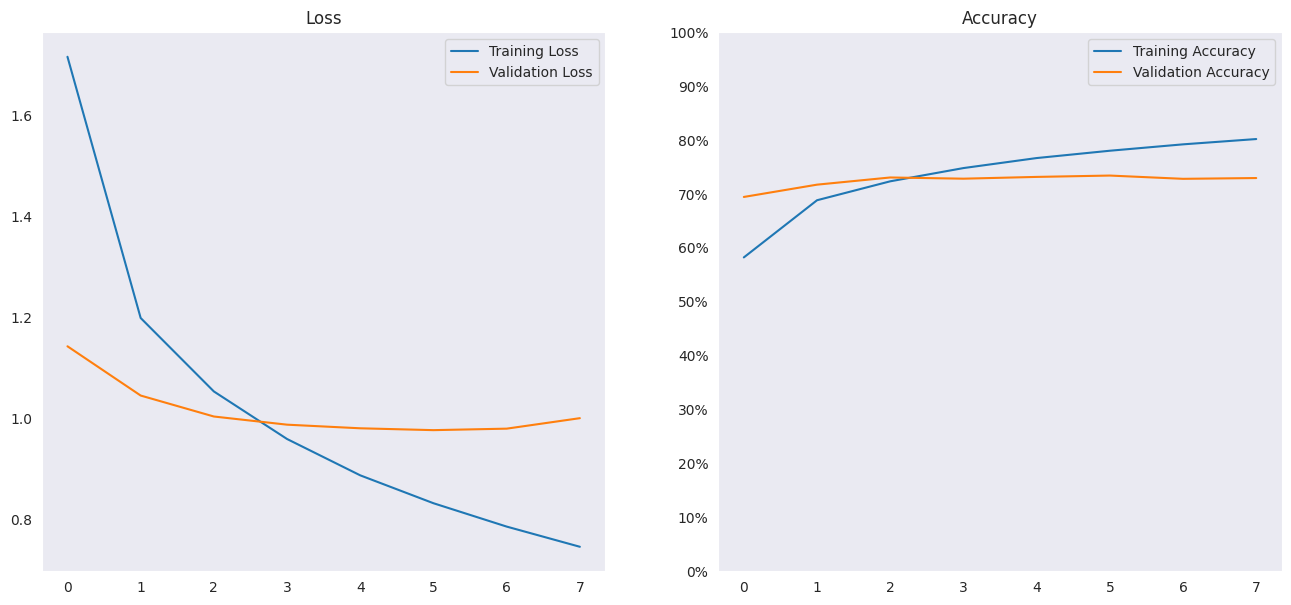

In [ ]:
plot_loss_curves(feature_extraction_model_history)

Seems like model is overfitting.

Let's fine tune it then let's see what happens

## Fine Tuning

In [ ]:
for layer in base_model.layers[-20:]:
    print(layer.name,layer.trainable)

block6d_project_conv False
block6d_project_bn False
block6d_drop False
block6d_add False
block7a_expand_conv False
block7a_expand_bn False
block7a_expand_activation False
block7a_dwconv False
block7a_bn False
block7a_activation False
block7a_se_squeeze False
block7a_se_reshape False
block7a_se_reduce False
block7a_se_expand False
block7a_se_excite False
block7a_project_conv False
block7a_project_bn False
top_conv False
top_bn False
top_activation False


In [ ]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [ ]:
for layer in base_model.layers[-20:]:
    print(layer.name,layer.trainable)

block6d_project_conv False
block6d_project_bn False
block6d_drop False
block6d_add False
block7a_expand_conv False
block7a_expand_bn False
block7a_expand_activation False
block7a_dwconv False
block7a_bn False
block7a_activation False
block7a_se_squeeze False
block7a_se_reshape False
block7a_se_reduce False
block7a_se_expand False
block7a_se_excite False
block7a_project_conv True
block7a_project_bn True
top_conv True
top_bn True
top_activation True


In [ ]:
# Recompile model with lower learning (it's typically best practice to lower the learning rate when fine-tuning so it dosen't update the learnt pattern too much)
model.compile(
    loss=SparseCategoricalCrossentropy(),
    optimizer=Adam(learning_rate=0.0001 ), # learning rate lowered by 10x
    metrics=["accuracy"]
)

In [ ]:
# Intialize the Project on Weights and Biases
run = wandb.init(project="Food_Vision")

# Fit the feature extraction model with callbacks
fine_tuned_model_history = model.fit(
    train_data,
    epochs=100,
    initial_epoch=(feature_extraction_model_history.epoch[-1]),
    steps_per_epoch=(len(train_data)),
    validation_data=test_data,
    validation_steps=int( 0.3 * len(test_data) ), # Evalutae on 30% of testing data for quicker results
    callbacks=[
        createTensorBoardCallback(
            model_name="Fine_Tuned_Model"
        ),
        WandbMetricsLogger(),
        model_checkpoint("Fine_Tuned_Model"),
        early_stopping()
    ]
)

Epoch 8/100
2368/2368 [==============================] - 207s 82ms/step - loss: 0.7255 - accuracy: 0.8073 - val_loss: 0.9450 - val_accuracy: 0.7439
Epoch 9/100
2368/2368 [==============================] - 196s 81ms/step - loss: 0.6098 - accuracy: 0.8392 - val_loss: 0.9367 - val_accuracy: 0.7463
Epoch 10/100
2368/2368 [==============================] - 196s 82ms/step - loss: 0.5275 - accuracy: 0.8629 - val_loss: 0.9339 - val_accuracy: 0.7509
Epoch 11/100
2368/2368 [==============================] - 197s 82ms/step - loss: 0.4593 - accuracy: 0.8826 - val_loss: 0.9422 - val_accuracy: 0.7520


In [ ]:
# Get the best model (Update the weights)
model.load_weights(f"{CHECKPOINT_PATH}/Fine_Tuned_Model/")

In [ ]:
# Save the model
model.save("Fine_Tuned_Model.h5")
# Upload it on Weights and Biases
wandb.save('Fine_Tuned_Model.h5')
# Finish the current run
wandb.finish()

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


epoch/accuracy,▁▄▆█
epoch/epoch,▁▃▆█
epoch/learning_rate,▁▁▁▁
epoch/loss,█▅▃▁
epoch/val_accuracy,▁▃▇█
epoch/val_loss,█▃▁▆
epoch/accuracy,0.88263
epoch/epoch,10
epoch/learning_rate,0.0001
epoch/loss,0.45931
epoch/val_accuracy,0.75198


In [ ]:
# Evaluate on full test data
fine_tuned_model_results = model.evaluate(test_data)
fine_tuned_model_results

790/790 [==============================] - 53s 66ms/step - loss: 0.9300 - accuracy: 0.7524


[0.9300158023834229, 0.7523960471153259]

In [ ]:
feature_extraction_model_results

[0.9766765236854553, 0.7332673072814941]

We can see that the Fine tuning has increased the accuracy by 2%

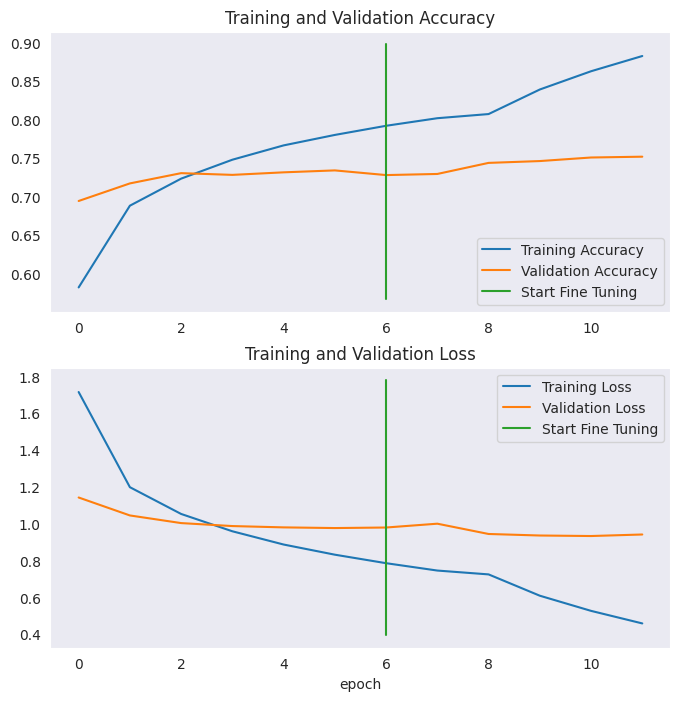

In [ ]:
compare_histories(
    feature_extraction_model_history,
    fine_tuned_model_history,
     (feature_extraction_model_history.epoch[-1]) )

> Let's create another fine tuned model but this time add regularization to reduce overfitting

In [ ]:
# Create base model
base_model = keras.applications.EfficientNetB0(include_top=False)
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

# Create functional model
inputs = Input(shape=INPUT_SHAPE,name="Input_Layer")
x = base_model(inputs,training=False)
x = GlobalAveragePooling2D(name="Global_Avg_Pooling_Layer")(x)

# Add a Dense layer with ElasticNet regularization
x = Dense(64, activation='relu',
          kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001), # ElasticNet regularization
          name="ElasticNet_Regularization_Layer")(x)

outputs = Dense(len(class_names), activation="softmax", dtype=tf.float32, name="Output_Layer")(x)

model = keras.Model(inputs, outputs)

# Compile the model
model.compile(
    loss=SparseCategoricalCrossentropy(),
    optimizer=Adam(),
    metrics=["accuracy"]
)

# Get the Summary of the Model
model.summary()

16705208/16705208 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 Global_Avg_Pooling_Layer (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 ElasticNet_Regularization_  (None, 64)                81984     
 Layer (Dense)                                                   
                                                                 
 Output_Layer (Dense)        (None, 101)               6565   

In [ ]:
# Intialize the Project on Weights and Biases
run = wandb.init(project="Food_Vision")

# Fit the feature extraction model with callbacks
fine_tuned_model_history = model.fit(
    train_data,
    epochs=100,
    steps_per_epoch=(len(train_data)),
    validation_data=test_data,
    validation_steps=int( 0.3 * len(test_data) ), # Evalutae on 30% of testing data for quicker results
    callbacks=[
        createTensorBoardCallback(
            model_name="Fine_Tuned_Model_Regularized"
        ),
        WandbMetricsLogger(),
        model_checkpoint("Fine_Tuned_Model_Regularized"),
        early_stopping()
    ]
)

wandb: Currently logged in as: vanshgawra008. Use `wandb login --relogin` to force relogin


Epoch 1/100
2368/2368 [==============================] - 224s 87ms/step - loss: 2.4803 - accuracy: 0.5122 - val_loss: 1.6997 - val_accuracy: 0.6287
Epoch 2/100
2368/2368 [==============================] - 207s 85ms/step - loss: 1.7522 - accuracy: 0.6221 - val_loss: 1.4699 - val_accuracy: 0.6759
Epoch 3/100
2368/2368 [==============================] - 204s 85ms/step - loss: 1.5727 - accuracy: 0.6572 - val_loss: 1.4422 - val_accuracy: 0.6874
Epoch 4/100
2368/2368 [==============================] - 211s 88ms/step - loss: 1.4661 - accuracy: 0.6790 - val_loss: 1.3678 - val_accuracy: 0.6904
Epoch 5/100
2368/2368 [==============================] - 199s 83ms/step - loss: 1.3849 - accuracy: 0.6959 - val_loss: 1.3573 - val_accuracy: 0.7024
Epoch 6/100
2368/2368 [==============================] - 198s 83ms/step - loss: 1.3219 - accuracy: 0.7102 - val_loss: 1.3830 - val_accuracy: 0.6920
Epoch 7/100
2368/2368 [==============================] - 204s 85ms/step - loss: 1.2760 - accuracy: 0.7226 - val_

In [ ]:
# Get the best model (Update the weights)
model.load_weights(f"{CHECKPOINT_PATH}/Fine_Tuned_Model_Regularized/")

In [ ]:
# Save the model
model.save("Fine_Tuned_Model_Regularized.h5")
# Upload it on Weights and Biases
wandb.save('Fine_Tuned_Model_Regularized.h5')
# Finish the current run
wandb.finish()

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


epoch/accuracy,▁▄▅▆▇▇▇██
epoch/epoch,▁▂▃▄▅▅▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▃▂▂▁▁▁
epoch/val_accuracy,▁▅▆▆▇▆███
epoch/val_loss,█▄▃▂▁▂▁▁▂
epoch/accuracy,0.7445
epoch/epoch,8
epoch/learning_rate,0.001
epoch/loss,1.18739
epoch/val_accuracy,0.71057


In [ ]:
# Evaluate on full test data
fine_tuned_model_regularized_results = model.evaluate(test_data)
fine_tuned_model_regularized_results

790/790 [==============================] - 56s 71ms/step - loss: 1.3366 - accuracy: 0.7070


[1.3365577459335327, 0.7070099115371704]

So, Reglarization dosen't work too well either

> In this case, Let's Continue with our fine tuned model

In [ ]:
best_model = wandb.restore('Fine_Tuned_Model.h5', run_path="vanshgawra008/Food_Vision/runs/gqj45wtq")
best_model = keras.models.load_model(best_model.name)

## Evaluate the Best Model

In [ ]:
best_model.evaluate(test_data)

790/790 [==============================] - 60s 63ms/step - loss: 0.9300 - accuracy: 0.7524


[0.9300158619880676, 0.7523960471153259]

> __So, We have got the accuracy score of 75.24% on test data on our food101 dataset which has 101 different types of food__

> Let's get the Prediction to evaluate it further

In [ ]:
pred_probs = best_model.predict(test_data)

790/790 [==============================] - 51s 63ms/step


In [ ]:
pred_probs[0]

array([1.7073856e-03, 1.1146996e-07, 1.0742522e-06, 3.4139662e-06,
       1.0681356e-05, 1.7436835e-06, 5.3483870e-08, 2.3647854e-06,
       1.6422218e-02, 1.9493134e-05, 6.3915526e-05, 7.6015908e-08,
       4.8347510e-04, 4.1192595e-04, 4.6495345e-04, 6.8283623e-07,
       1.1418154e-03, 4.9301080e-04, 8.3311802e-09, 1.6160377e-05,
       7.0155566e-09, 2.1837796e-03, 3.7074855e-03, 1.1459421e-05,
       5.8864163e-07, 1.5117568e-07, 1.2294165e-05, 1.5272760e-04,
       9.1362481e-06, 8.2843101e-01, 1.3016441e-02, 3.1707072e-04,
       1.0719962e-07, 7.0961355e-11, 1.2059975e-03, 1.6439591e-08,
       1.5943316e-04, 2.3414546e-07, 4.4433003e-07, 1.4683287e-06,
       1.5236137e-07, 1.0888776e-07, 1.3478164e-04, 1.1210828e-08,
       2.3414546e-07, 8.8972956e-02, 2.1654914e-07, 1.1933865e-08,
       1.0493671e-06, 6.4281530e-06, 9.4603323e-08, 7.2687538e-07,
       2.2042223e-06, 4.5857145e-05, 2.9245193e-09, 1.9604761e-06,
       1.4829593e-05, 1.3293163e-05, 1.8142270e-02, 1.4538423e

In [ ]:
len(pred_probs)

25250

In [ ]:
y_preds = pred_probs.argmax(axis=1)

In [ ]:
len(y_preds)

25250

In [ ]:
len(test_data)

790

To compare it we have to unbatch the test data

In [ ]:
y_true = []
for image, label in test_data.unbatch():
  y_true.append(label.numpy())

In [ ]:
len(y_true),len(pred_probs),len(y_preds)

(25250, 25250, 25250)

In [ ]:
y_true[:10], y_preds[:10]

([29, 81, 91, 53, 97, 97, 10, 31, 3, 100],
 array([29, 81, 91, 53, 97, 97, 10, 31,  3, 94]))

> Let's get the Precision,Recall and F-1 Score class wise

In [ ]:
print(classification_report(y_true, y_preds))

              precision    recall  f1-score   support

           0       0.57      0.51      0.54       250
           1       0.76      0.74      0.75       250
           2       0.84      0.76      0.80       250
           3       0.85      0.72      0.78       250
           4       0.67      0.63      0.65       250
           5       0.58      0.67      0.62       250
           6       0.87      0.80      0.84       250
           7       0.83      0.91      0.87       250
           8       0.55      0.62      0.59       250
           9       0.70      0.66      0.68       250
          10       0.74      0.55      0.63       250
          11       0.79      0.80      0.80       250
          12       0.82      0.81      0.81       250
          13       0.75      0.74      0.74       250
          14       0.76      0.70      0.73       250
          15       0.61      0.58      0.59       250
          16       0.57      0.60      0.58       250
          17       0.73    

Let's Visualize these metrics

In [ ]:
classification_report_dict = classification_report(y_true, y_preds, output_dict=True)
classification_report_dict

{'0': {'precision': 0.5669642857142857,
  'recall': 0.508,
  'f1-score': 0.5358649789029537,
  'support': 250},
 '1': {'precision': 0.757201646090535,
  'recall': 0.736,
  'f1-score': 0.746450304259635,
  'support': 250},
 '2': {'precision': 0.84,
  'recall': 0.756,
  'f1-score': 0.7957894736842104,
  'support': 250},
 '3': {'precision': 0.8530805687203792,
  'recall': 0.72,
  'f1-score': 0.7809110629067245,
  'support': 250},
 '4': {'precision': 0.6709401709401709,
  'recall': 0.628,
  'f1-score': 0.6487603305785123,
  'support': 250},
 '5': {'precision': 0.5813148788927336,
  'recall': 0.672,
  'f1-score': 0.6233766233766234,
  'support': 250},
 '6': {'precision': 0.8739130434782608,
  'recall': 0.804,
  'f1-score': 0.8375,
  'support': 250},
 '7': {'precision': 0.8345588235294118,
  'recall': 0.908,
  'f1-score': 0.8697318007662836,
  'support': 250},
 '8': {'precision': 0.5512367491166078,
  'recall': 0.624,
  'f1-score': 0.5853658536585366,
  'support': 250},
 '9': {'precision': 0

In [ ]:
# Create empty dictionary
class_metrics = []
# Loop through classification report dictionary items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Add class names and their metrics
    class_metrics.append( (class_names[int(k)],v["precision"],v["recall"],v["f1-score"]  ) )
metrics_df = pd.DataFrame(class_metrics,columns=["Food","Precision","Recall","F1-score"])
metrics_df

,Food,Precision,Recall,F1-score
0,apple_pie,0.566964,0.508,0.535865
1,baby_back_ribs,0.757202,0.736,0.746450
2,baklava,0.840000,0.756,0.795789
3,beef_carpaccio,0.853081,0.720,0.780911
4,beef_tartare,0.670940,0.628,0.648760
...,...,...,...,...
96,tacos,0.535088,0.732,0.618243
97,takoyaki,0.884120,0.824,0.853002
98,tiramisu,0.641379,0.744,0.688889
99,tuna_tartare,0.514469,0.640,0.570410


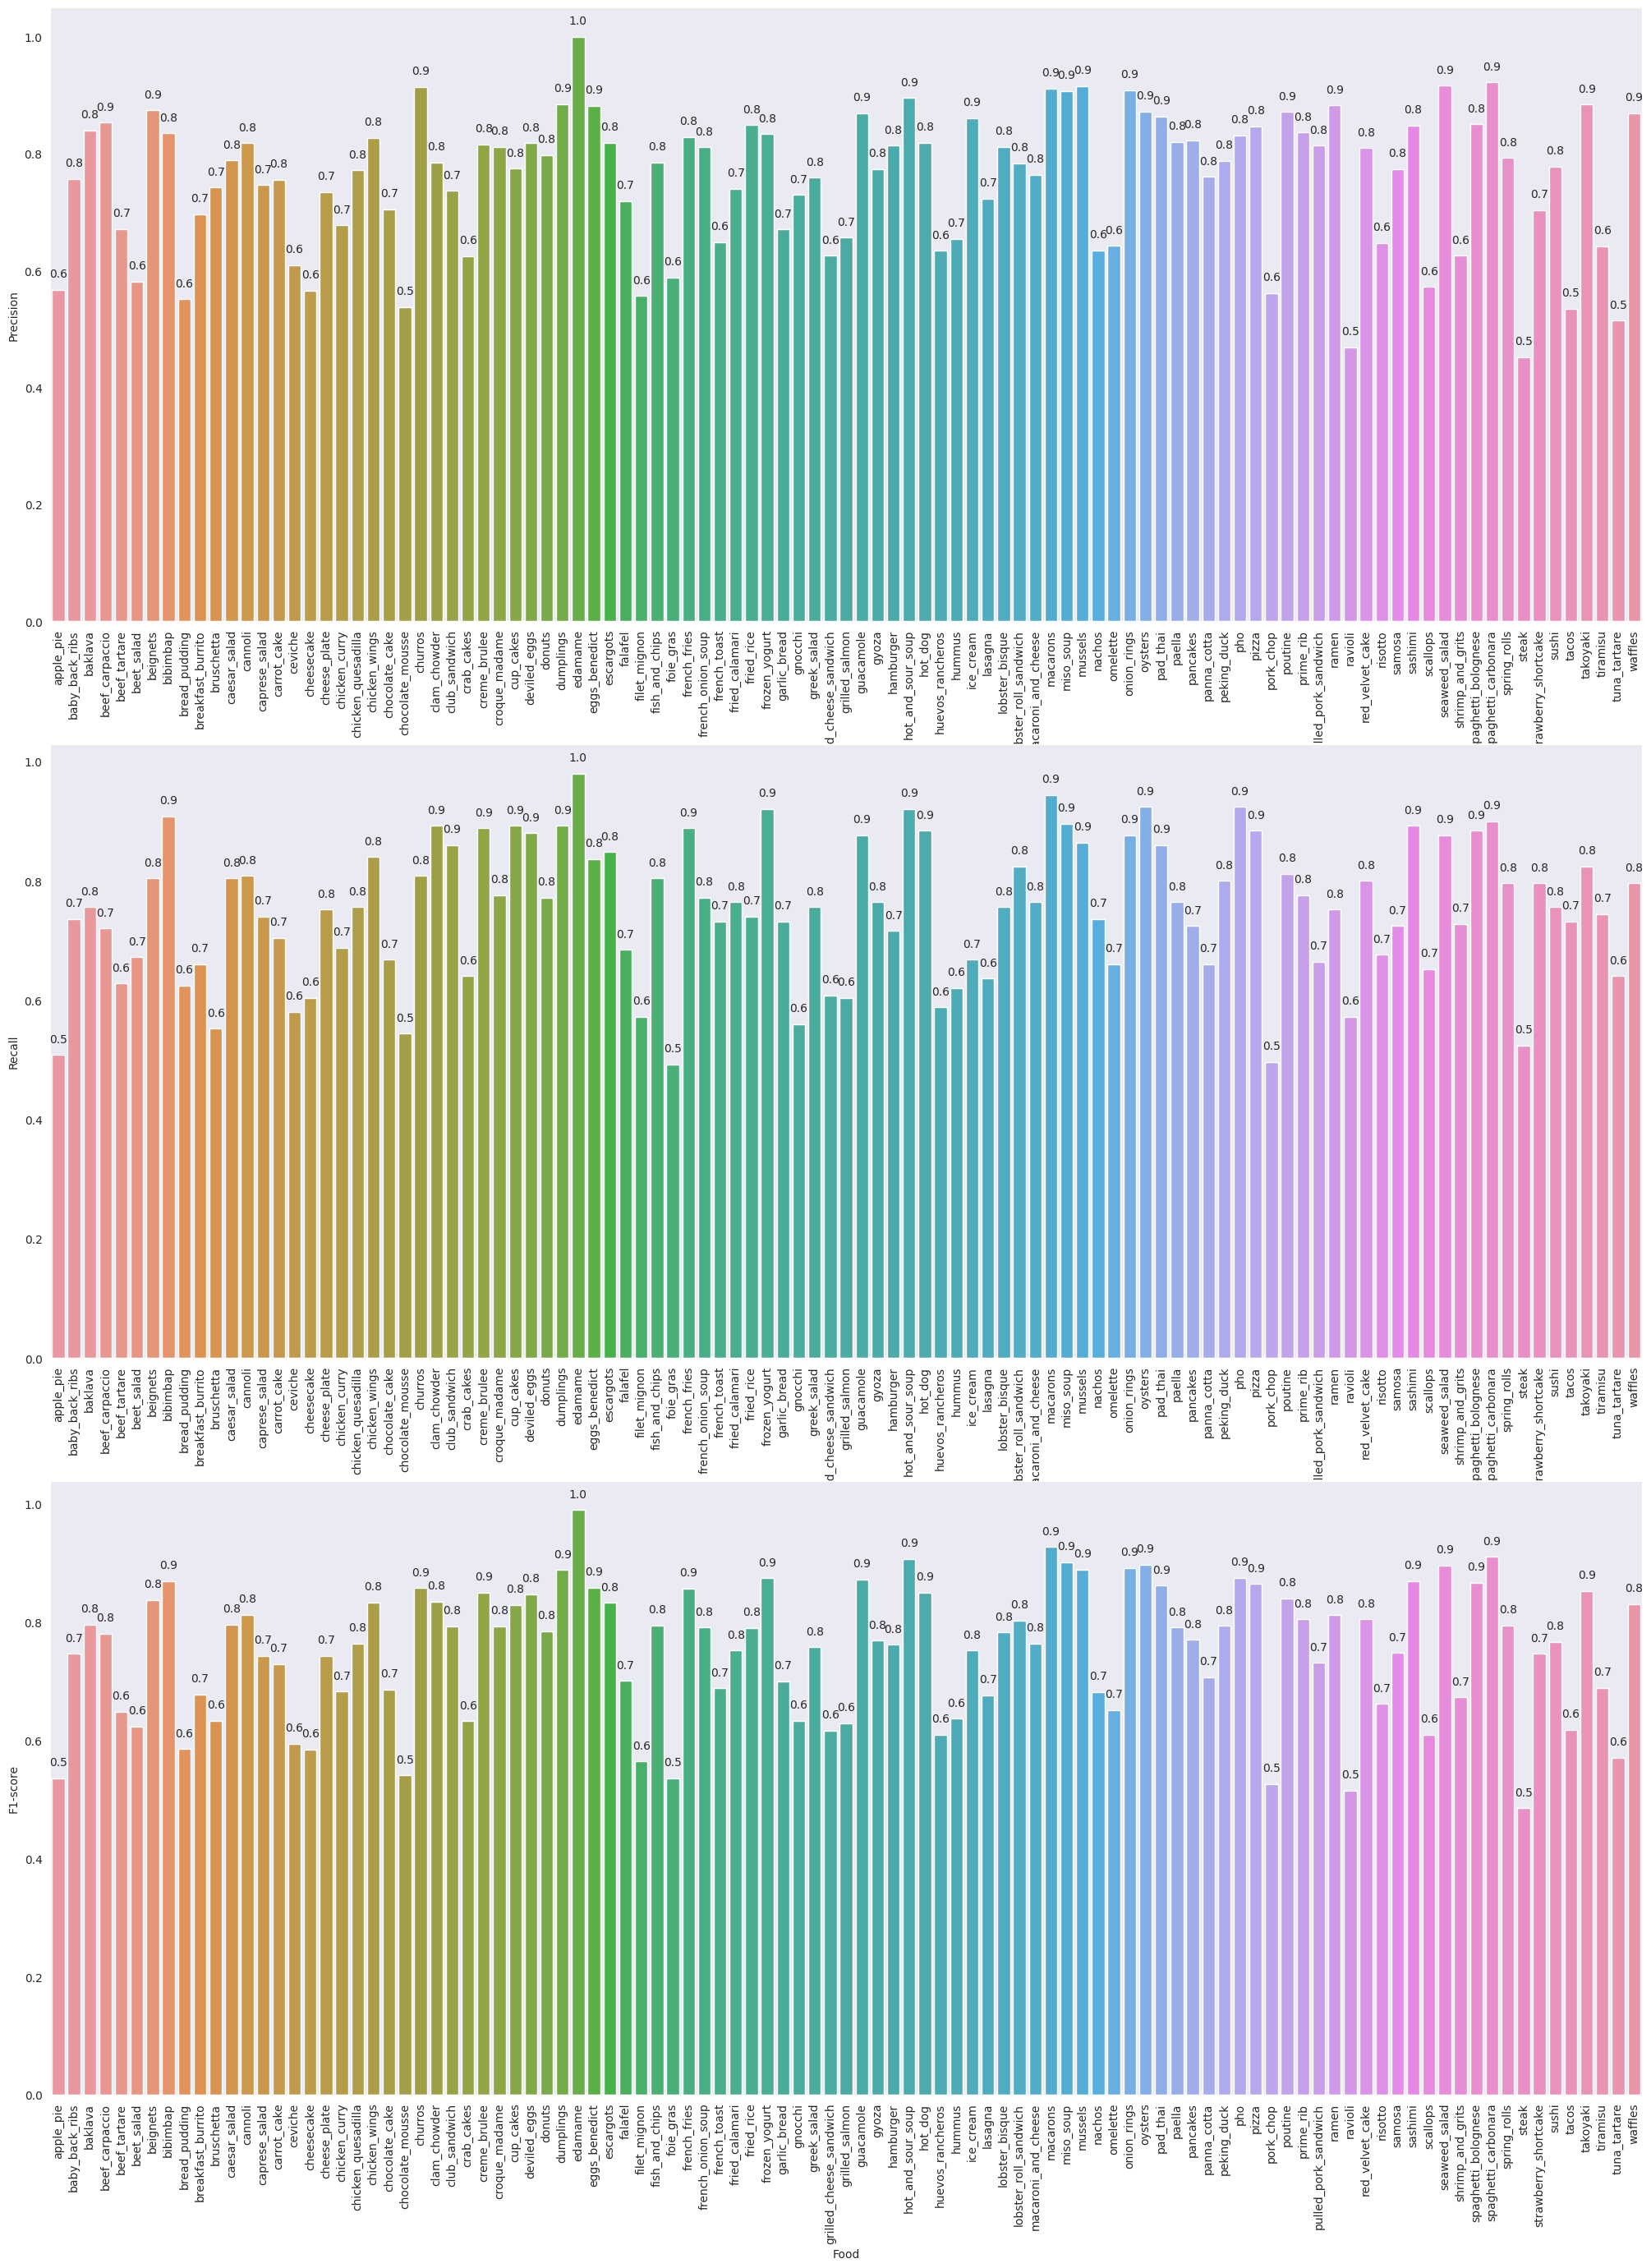

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=3,figsize=(25,33))
# Precision
sns.barplot(x=metrics_df["Food"], y=metrics_df["Precision"], ax=ax1)
for p in ax1.patches:
    ax1.annotate(format(p.get_height(), '.1f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'bottom',
                xytext = (0, 9),
                textcoords = 'offset points',
                fontsize=10)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
# Recall
sns.barplot(x=metrics_df["Food"], y=metrics_df["Recall"], ax=ax2)
for p in ax2.patches:
    ax2.annotate(format(p.get_height(), '.1f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'bottom',
                xytext = (0, 9),
                textcoords = 'offset points',
                fontsize=10)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
# F1-Score
sns.barplot(x=metrics_df["Food"], y=metrics_df["F1-score"], ax=ax3)
for p in ax3.patches:
    ax3.annotate(format(p.get_height(), '.1f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'bottom',
                xytext = (0, 9),
                textcoords = 'offset points',
                fontsize=10)
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=90)
plt.show()

> Looks like for majority classes precison,recall and F1-score is 0.7 and above

> Let's Confirm it using the HistPlots

<Axes: xlabel='F1-score', ylabel='Count'>

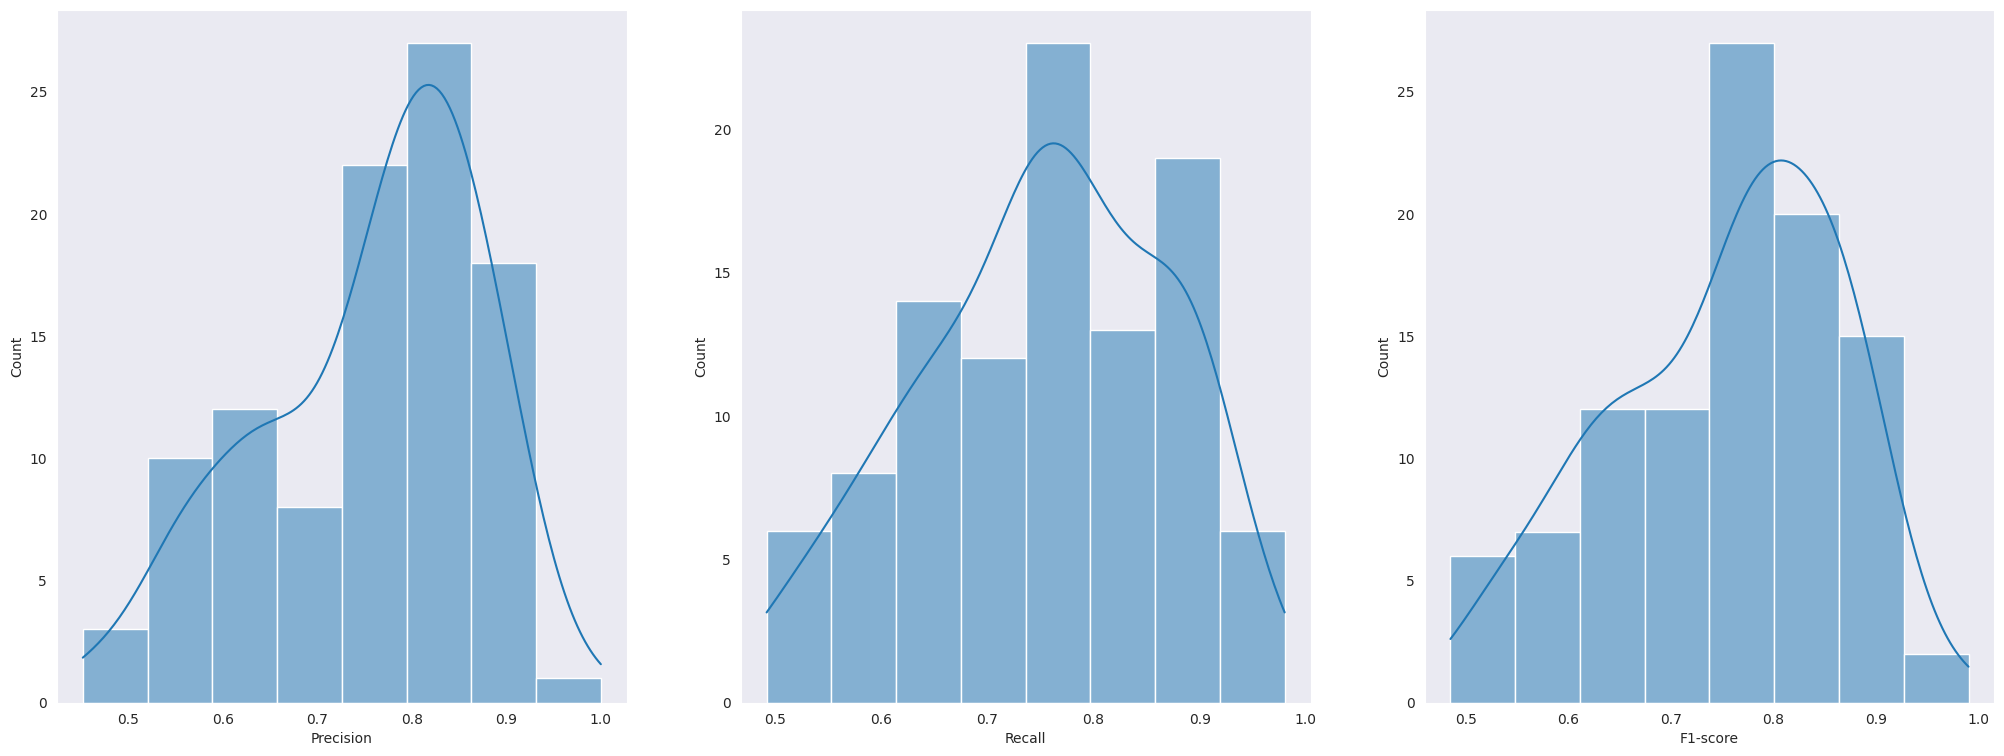

In [ ]:
 fig, (ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(25,9))
sns.histplot(metrics_df["Precision"],kde=True,ax=ax1)
sns.histplot(metrics_df["Recall"],kde=True,ax=ax2)
sns.histplot(metrics_df["F1-score"],kde=True,ax=ax3)

> __We can clearly observe that the majority classes have Precison, Recall & F1-score of 0.7 and above.__

### Let's Get The Confusion Matrix

In [ ]:
conf_mat = confusion_matrix(y_true,y_preds)
conf_mat.shape

(101, 101)

> __101 classes are too much to display in a single Confusion matrix so we will divide it in 10__

In [ ]:
conf_mats = []
labels = []
for i in range(0,len(conf_mat)-11,10):
    conf_mats.append( conf_mat[i:i+10,i:i+10] )
    labels.append( class_names[i:i+10] )
conf_mats.append(conf_mat[-11:,-11:])
labels.append( class_names[-11:] )
len(conf_mats), len(labels)

(10, 10)

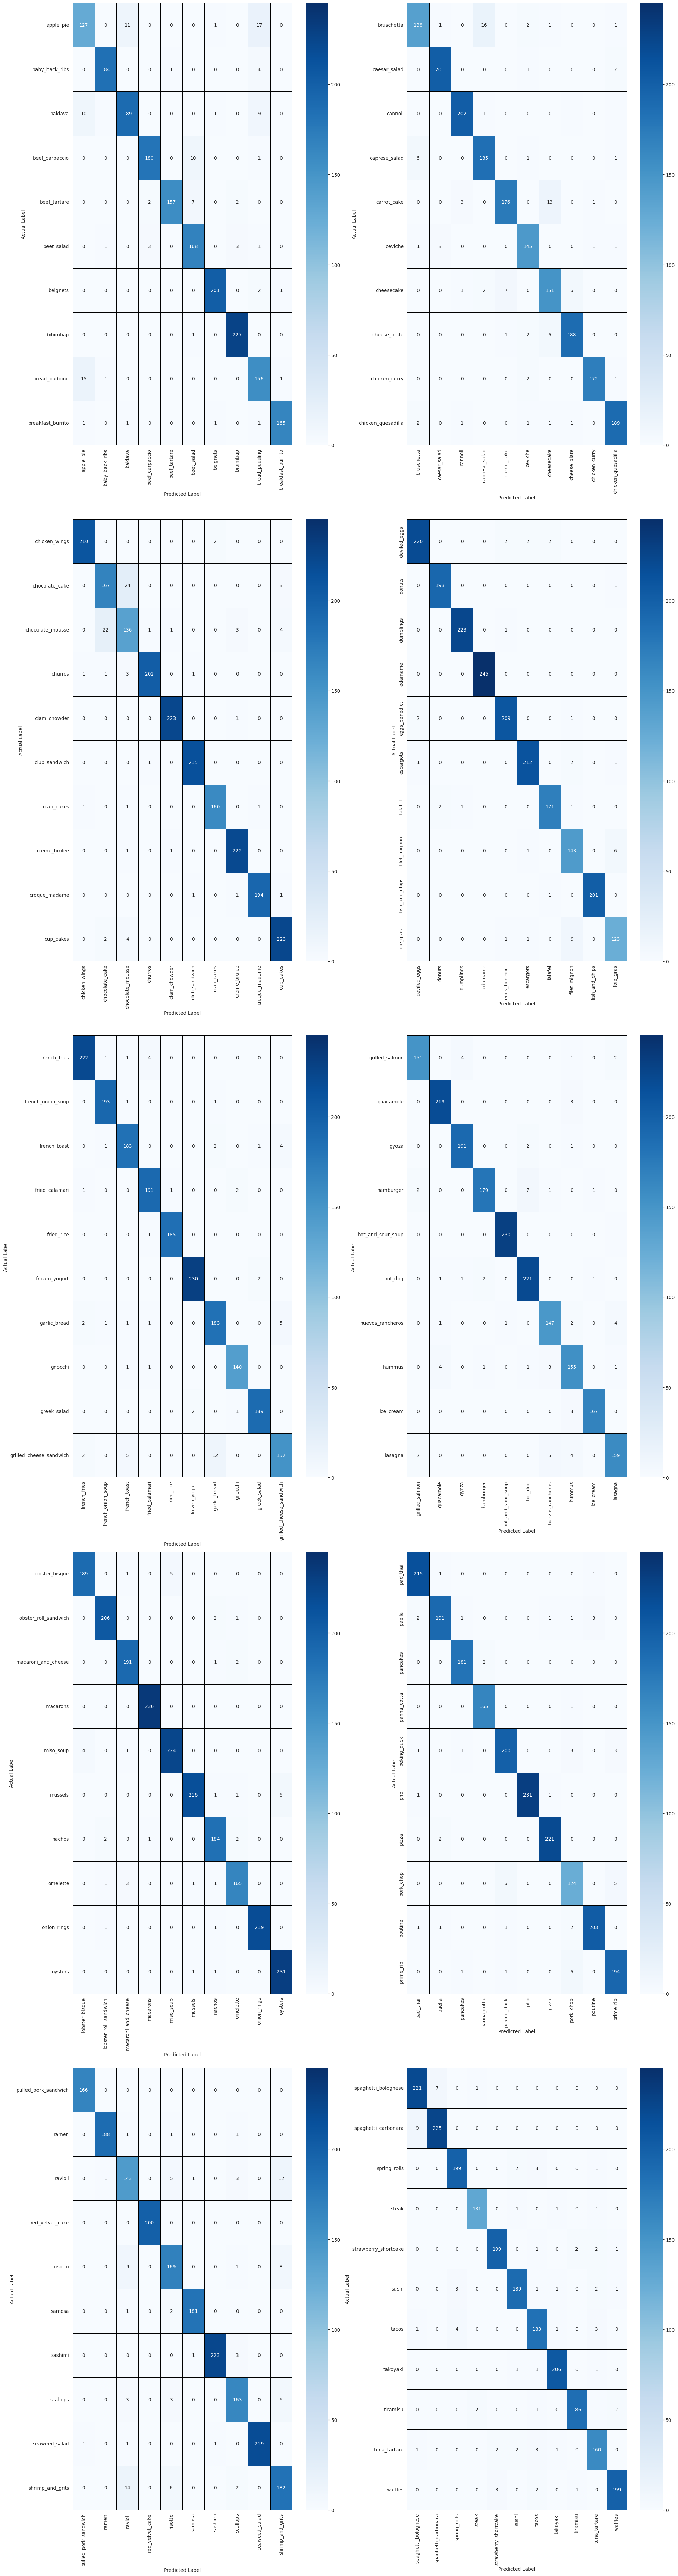

In [ ]:
fig,ax = plt.subplots(nrows=5,ncols=2,figsize=(20,75) )
x = 0
mx = np.max(conf_mat)
for row in range(5):
    for col in range(2):
        sns.heatmap( conf_mats[x] ,ax=ax[row][col],cmap="Blues",fmt=".0f",annot=True,vmin=0,vmax=mx , xticklabels=labels[x],yticklabels=labels[x],linewidths=0.5,linecolor="black" )
        ax[row][col].set_xlabel("Predicted Label")
        ax[row][col].set_ylabel("Actual Label")
        x += 1
plt.tight_layout()
plt.show()

### Let's Visualize the Model's Prediction with examples

1/1 [==============================] - 0s 59ms/step


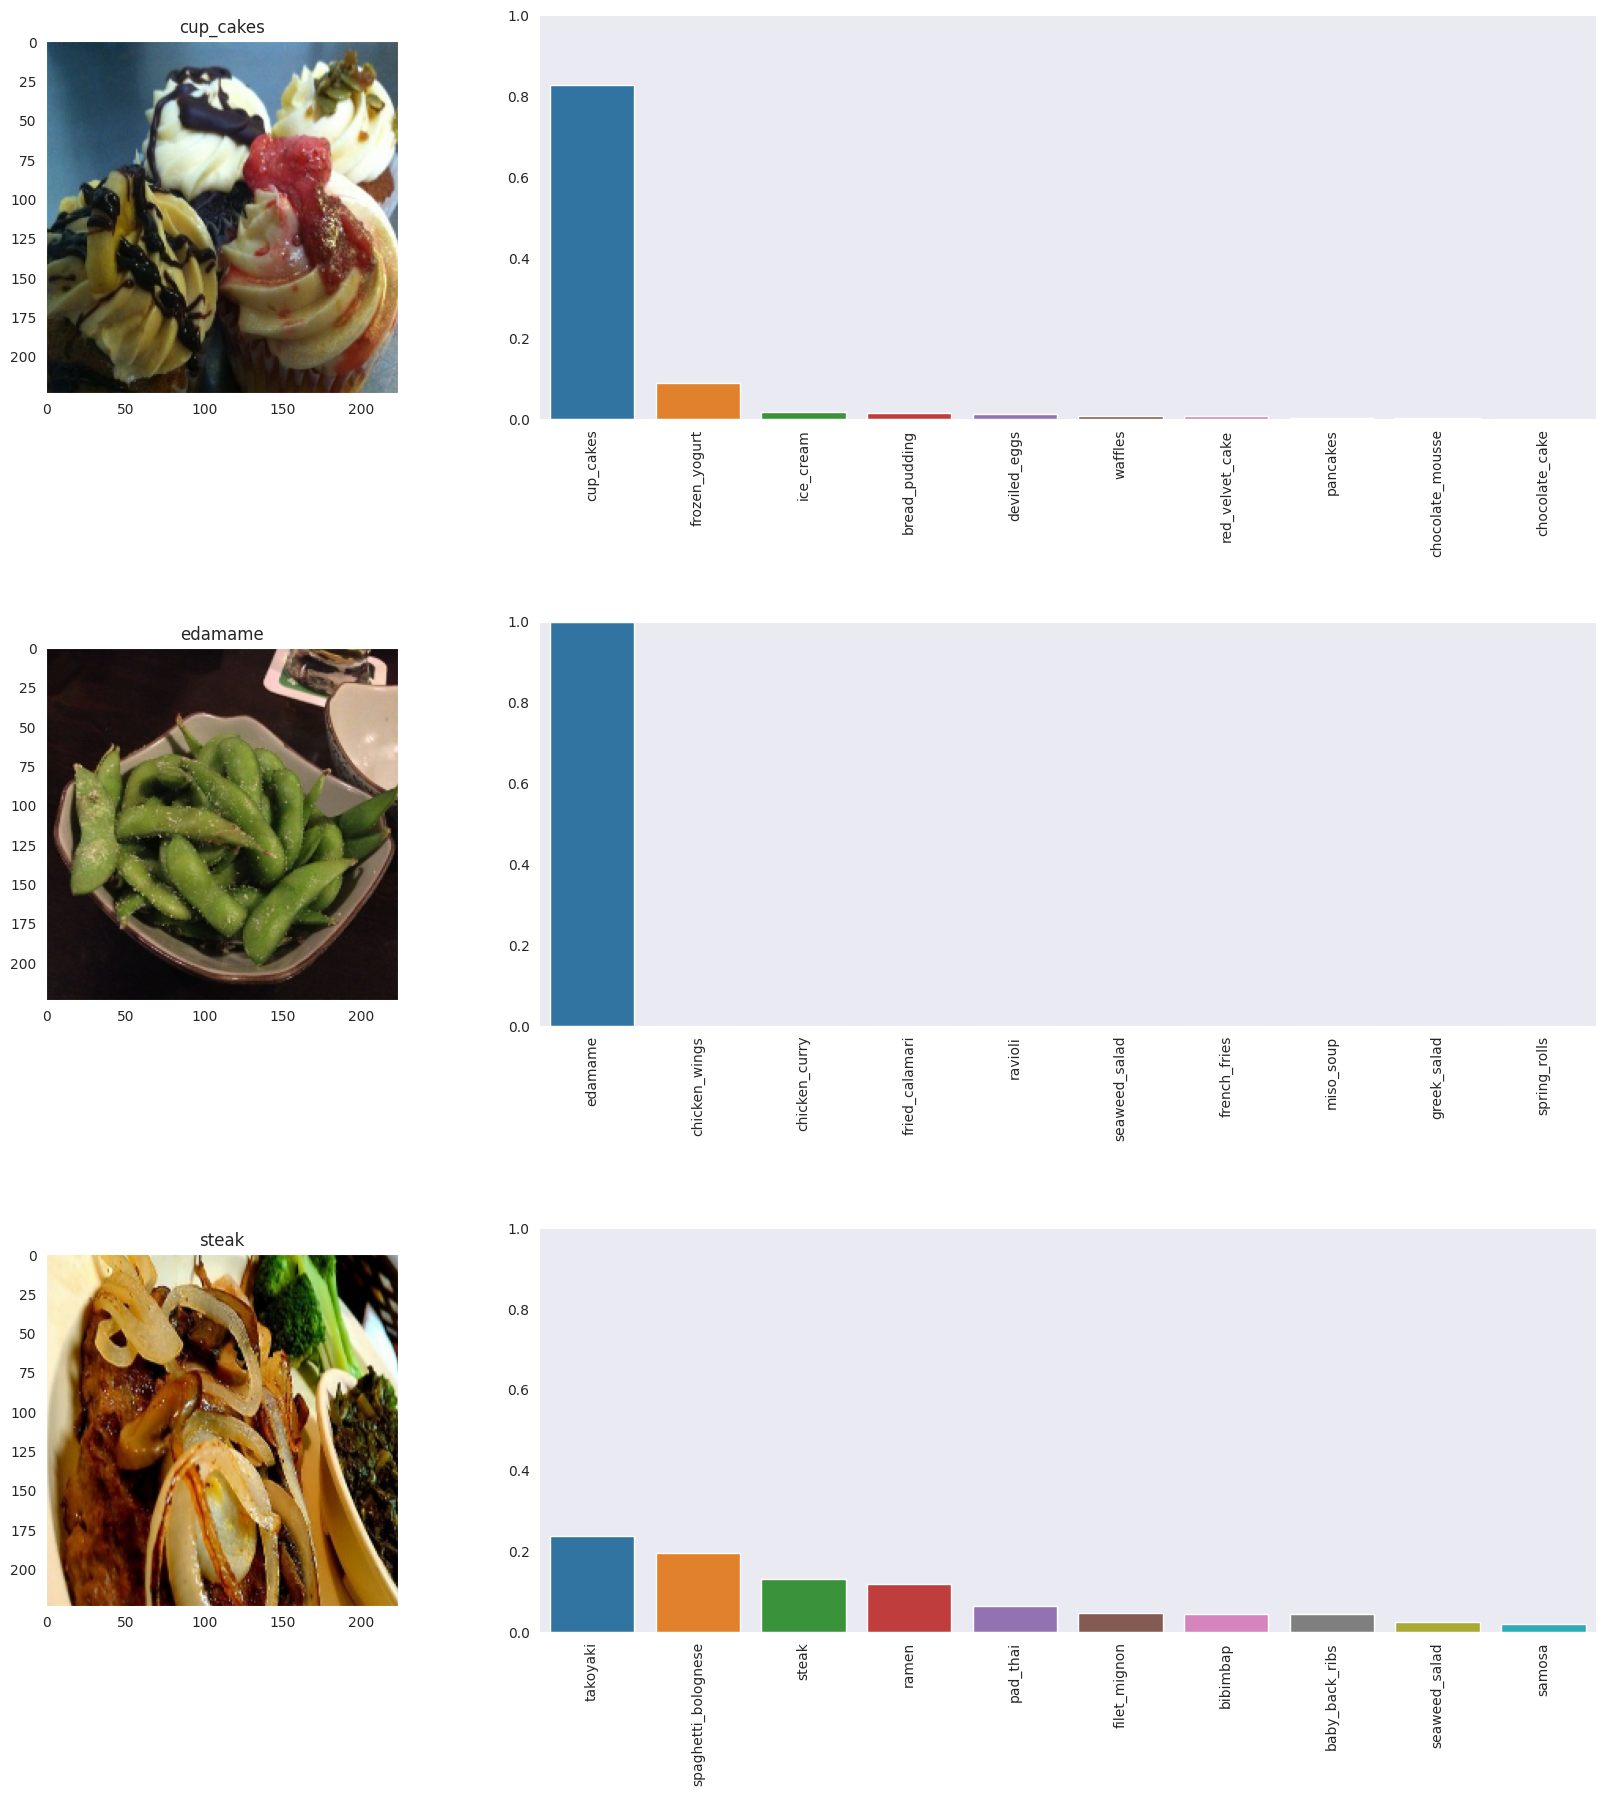

In [ ]:
random_plot_predict(best_model,3)